In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

tf.config.list_physical_devices('GPU')

%matplotlib inline

## Data preprocessing

After importing the AddNIST dataset, the x-values are normalized in the range 0-1.
The y-values are one-hot encoded to ensure that all classes have the same importance to the model during training.

After the x-values are normalized, they are then reshaped to follow the Keras/Tensorflow *channels_last* data format, and resized to 32x32 to fit the model input shape.

In [4]:
def preprocess_data(x, y):
    
    processed_x = (x - x.min())/x.ptp().astype('float32')
    
    processed_y = to_categorical(y, 20)
    
    return processed_x, processed_y

In [5]:
x_train = np.load("train_x.npy", allow_pickle=True)
y_train = np.load("train_y.npy", allow_pickle=True)

x_val = np.load("valid_x.npy", allow_pickle=True)
y_val = np.load("valid_y.npy", allow_pickle=True)

x_test = np.load("test_x.npy", allow_pickle=True)
y_test = np.load("test_y.npy", allow_pickle=True)

In [6]:
x_train, y_train = preprocess_data(x_train, y_train)
x_val, y_val = preprocess_data(x_val, y_val)


x_train = np.moveaxis(x_train, 1, -1)
x_train = tf.image.resize(x_train, (32, 32))

x_val = np.moveaxis(x_val, 1, -1)
x_val = tf.image.resize(x_val, (32, 32))


In [7]:
# print(x_train.shape)
# print(x_val.shape)
# print(y_train[1])

# plt.imshow(x_train[1])

## Building, compiling, and training the model

The model is a convolutional neural network, like in Part 1. This time, a much deeper convolutional neural network is used, with three convolution blocks, each with two convolutional layers with ReLU activation and max pooling. The overfitting problem of the previous model is addressed by adding a dropout layer to the second and third convolution blocks. To improve feature selection, two hidden fully connected layers with ReLU activation are added, before applying batch normalization and getting the final 20 class prediction with a final softmax fully connected layer.

After experimenting with stochastic gradient descent learning rates, the combination of categorical cross-entropy and Adam optimizer still provided the highest accuracy and lowest loss scores. The relatively small size of the neural network allowed for it to be trained for 20 epochs with a batch size of 64, yielding significantly better results than with fewer epochs.

In [8]:
initializer = glorot_uniform(seed=32)
shape = (32,32,3)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=initializer,input_shape=shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(20, activation='softmax'))    


model.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
                metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0

In [16]:
history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
704/704 [==============================] - 15s 20ms/step - loss: 0.2498 - accuracy: 0.9180 - val_loss: 0.4489 - val_accuracy: 0.8814
Epoch 2/20
171/704 [======>.......................] - ETA: 9s - loss: 0.2553 - accuracy: 0.9158 - ETA: 10s - los

KeyboardInterrupt: 

## Evaluating the model

The model achieved 91% accuracy while training, 87% accuracy on the validation dataset, and 89% accuracy on the AddNIST testing dataset.
Before getting a prediction, the test x-values are preprocessed the same way as the training data. The test y-values are not one-hot encoded, to generate the classification report.

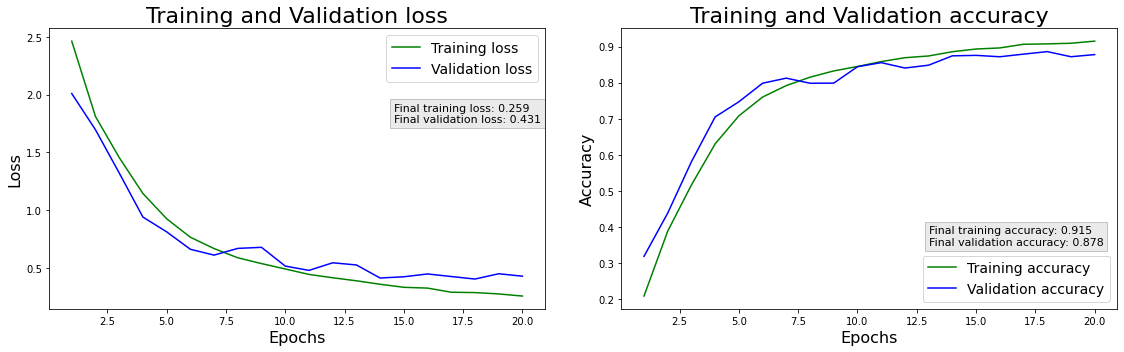

In [10]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


fig, (ax1,ax2) = plt.subplots(1, 2) 
fig.set_size_inches(16, 5)
epochs = range(1,21)

ax1.plot(epochs, train_loss, 'g', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and Validation loss', fontsize = 22)
ax1.set_xlabel('Epochs', fontsize = 16)
ax1.set_ylabel('Loss', fontsize = 16)
ax1.legend(fontsize = 14)

ax2.plot(epochs, train_accuracy, 'g', label='Training accuracy')
ax2.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax2.set_title('Training and Validation accuracy', fontsize = 22)
ax2.set_xlabel('Epochs', fontsize = 16)
ax2.set_ylabel('Accuracy', fontsize = 16)
ax2.legend(fontsize = 14)

f_loss = [train_loss[-1], val_loss[-1]]
final_loss = "Final training loss: {}\nFinal validation loss: {}".format(round(f_loss[0], 3), round(f_loss[1], 3))

ax1.text(14.6, 1.76, final_loss, fontsize = 11, 
         bbox = dict(facecolor = '#969696', alpha = 0.2))

f_acc = [train_accuracy[-1], val_accuracy[-1]]
final_accuracy = "Final training accuracy: {}\nFinal validation accuracy: {}".format(round(f_acc[0], 3), round(f_acc[1], 3))

ax2.text(13, 0.35, final_accuracy, fontsize = 11, 
         bbox = dict(facecolor = '#969696', alpha = 0.2))


plt.tight_layout()
plt.savefig('Part 3 Training and Validation loss and accuracy.png', dpi=200, format='png', bbox_inches='tight')

In [11]:
'''
Plotting scikit-learn classification report as a heatmap
Source: https://stackoverflow.com/questions/28200786/ 
By Franck Dernoncourt
'''

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(figure_width, figure_height)



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 12
    figure_height = 18
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [12]:
x_test = (x_test - x_test.min())/x_test.ptp().astype('float32')
x_test = np.moveaxis(x_test, 1, -1)
x_test = tf.image.resize(x_test, (32, 32))

In [13]:
prediction = np.argmax(model.predict(x_test), axis=-1)

[0.97, 0.99, 0.98]
[0.93, 0.97, 0.95]
[0.93, 0.96, 0.94]
[0.93, 0.96, 0.94]
[0.92, 0.93, 0.92]
[0.93, 0.91, 0.92]
[0.89, 0.9, 0.9]
[0.86, 0.91, 0.89]
[0.91, 0.89, 0.9]
[0.91, 0.87, 0.89]
[0.85, 0.86, 0.85]
[0.88, 0.84, 0.86]
[0.86, 0.88, 0.87]
[0.83, 0.81, 0.82]
[0.82, 0.85, 0.84]
[0.85, 0.83, 0.84]
[0.86, 0.86, 0.86]
[0.87, 0.85, 0.86]
[0.9, 0.9, 0.9]
[0.91, 0.87, 0.89]
plotMat: [[0.97, 0.99, 0.98], [0.93, 0.97, 0.95], [0.93, 0.96, 0.94], [0.93, 0.96, 0.94], [0.92, 0.93, 0.92], [0.93, 0.91, 0.92], [0.89, 0.9, 0.9], [0.86, 0.91, 0.89], [0.91, 0.89, 0.9], [0.91, 0.87, 0.89], [0.85, 0.86, 0.85], [0.88, 0.84, 0.86], [0.86, 0.88, 0.87], [0.83, 0.81, 0.82], [0.82, 0.85, 0.84], [0.85, 0.83, 0.84], [0.86, 0.86, 0.86], [0.87, 0.85, 0.86], [0.9, 0.9, 0.9], [0.91, 0.87, 0.89]]
support: [395, 423, 454, 504, 447, 544, 497, 466, 527, 534, 531, 544, 536, 506, 519, 507, 477, 518, 532, 539]


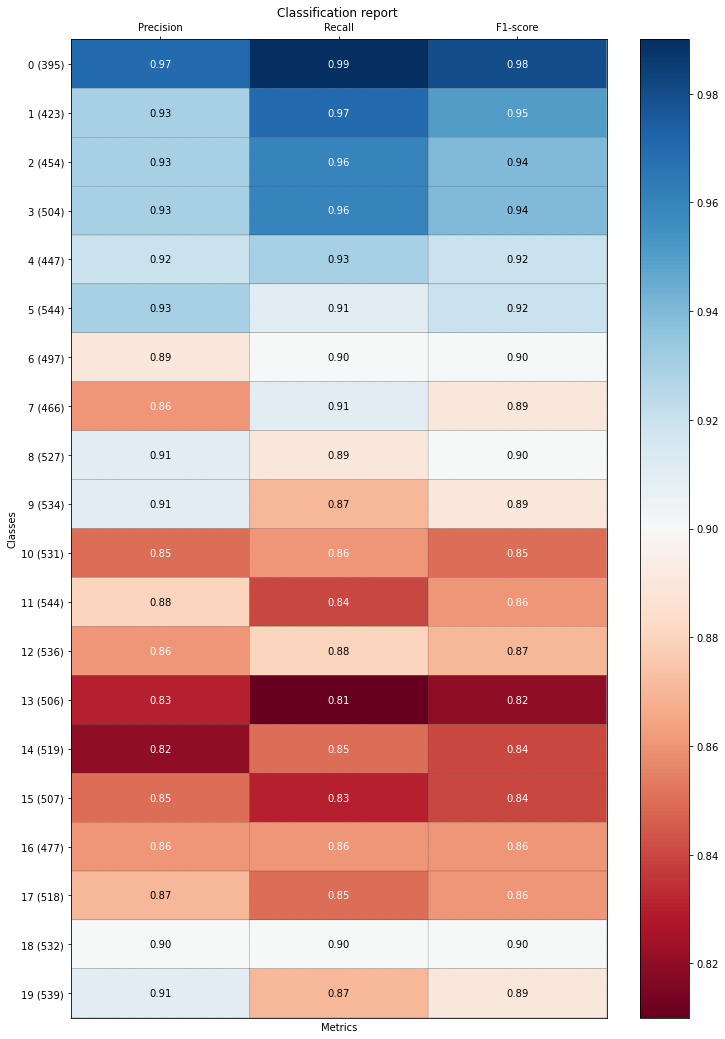

In [14]:
report = classification_report(y_test, prediction)
plot_classification_report(report)
plt.savefig('Part 3 Classification Report.png', dpi=200, format='png', bbox_inches='tight')

In [15]:
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       395
           1       0.93      0.97      0.95       423
           2       0.93      0.96      0.94       454
           3       0.93      0.96      0.94       504
           4       0.92      0.93      0.92       447
           5       0.93      0.91      0.92       544
           6       0.89      0.90      0.90       497
           7       0.86      0.91      0.89       466
           8       0.91      0.89      0.90       527
           9       0.91      0.87      0.89       534
          10       0.85      0.86      0.85       531
          11       0.88      0.84      0.86       544
          12       0.86      0.88      0.87       536
          13       0.83      0.81      0.82       506
          14       0.82      0.85      0.84       519
          15       0.85      0.83      0.84       507
          16       0.86      0.86      0.86       477
          17       0.87    